In [1]:
# loading libraries
library(tidymodels)
library(tidyverse)
library(tidyclust)
library(forcats)
library(repr)
library(GGally)
# specify the width and height of the graph
options(repr.matrix.max.rows=6)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ recipes      1.1.0
✔ dials        1.3.0     ✔ rsample      1.2.1
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.5.1     ✔ tidyr        1.3.1
✔ infer        1.0.7     ✔ tune         1.1.2
✔ modeldata    1.4.0     ✔ workflows    1.1.4
✔ parsnip      1.2.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.3.1

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use tidymodels_prefer() to resolve common conflicts.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.5
✔ lubridate 1.9.3     ✔ stringr   1.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::

## Behavioral Predictions of Newsletter Subscription Across Different  Players Types

A group of researchers is interested in collecting data on how individuals engage with video games. To support their investigation, they have a MineCraft server to record players' action as they navigate through the world. However, serveral important considerations has to be addressed to ensure the successful execution of the research. This project aims to explore the following question: How does a individual's experience and gender influence the likelyhood of subscribing to a newsletter in `players.csv`?

To begin the analysis, we start by examine the dataset `players.csv`, which will be used to explore the research question. The dataset was collected from an online MineCraft server created by a research group at UBC. 

In [2]:
players_data <- read_csv("data/players.csv")
players_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


The data set above has 7 variables, which are: `experience`, `subscribe`,`hashedEmail`,`played_hours`,`name`,`gender`, and `age`. There are 196 observations, thus 196 individuals participated to the collection of the data. The meaning of each variable is presented below.
* `experience`: the player's experience level in MineCraft
* `subscribe` : the player subscribed to a newsletter or service
* `hashedEmail`: a hashed version of the player's email address
* `played_hours` :total number of hours the player has spent playing on MineCraft server
* `name` : the player's name
* `gender` : the player's self-reported gender
* `age` : the player's self-reported or estimated age

There are some minor problems in this dataset, such as the variable `play_hours` has an underscore, the `Age` is double and capitalized. However, these problems will not significantly affect the analysis.

## Data Processing and Analysis
We will start the analysis by selecting the variables for the question, which is `experience`, `subscribe`, and `gender`. From the data set above, `experience` and `gender` are expressed as charaters, thus for future analysis we will change both variables into factors, allowing us to plot experience as groups.

In [3]:
players <- players_data|>
    select(experience, subscribe, gender)|>
    mutate(experience=as_factor(experience))|>
    mutate(gender=as_factor(gender))

players

experience,subscribe,gender
<fct>,<lgl>,<fct>
Pro,TRUE,Male
Veteran,TRUE,Male
Veteran,FALSE,Male
⋮,⋮,⋮
Amateur,FALSE,Prefer not to say
Amateur,FALSE,Male
Pro,TRUE,Other


It is challenging to identify the relationships directly from a data table, therefore a bar plot would be useful to visually examine the association between the variables that we are interested in.

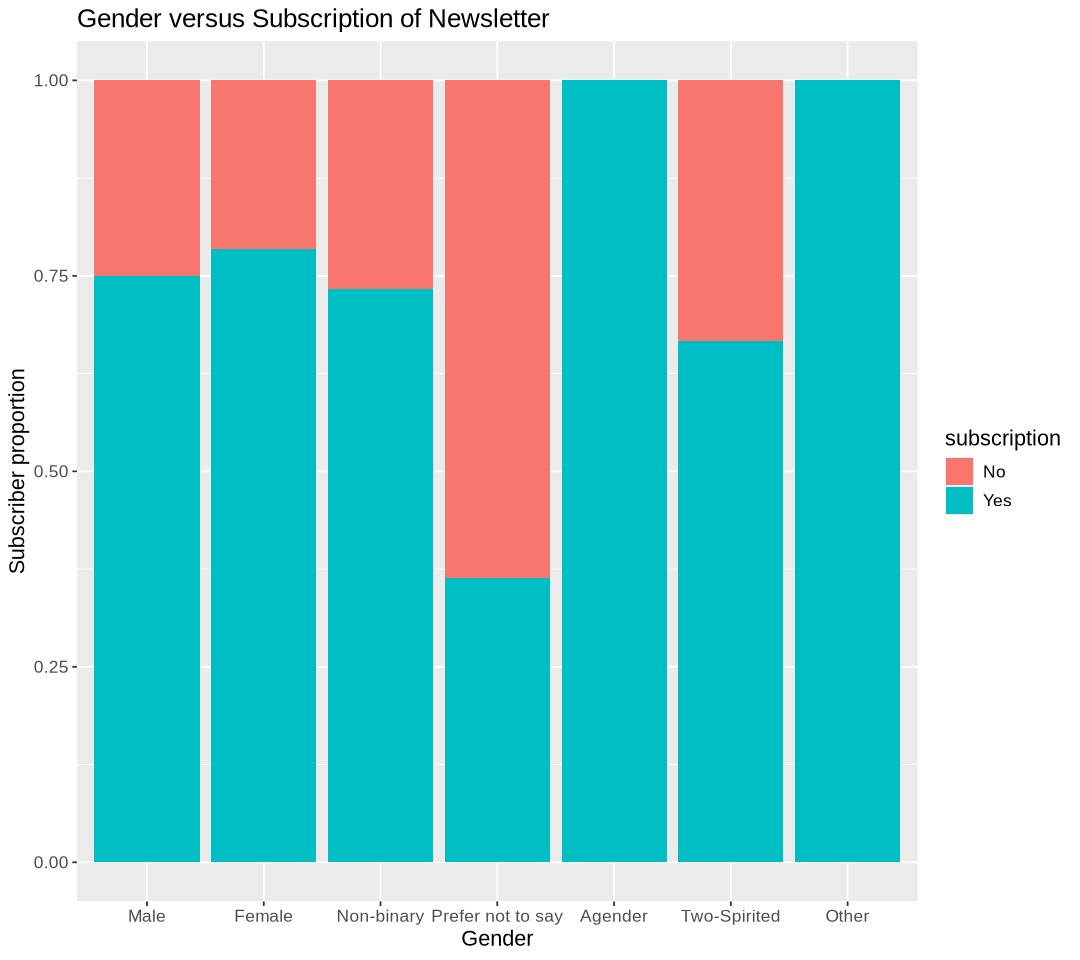

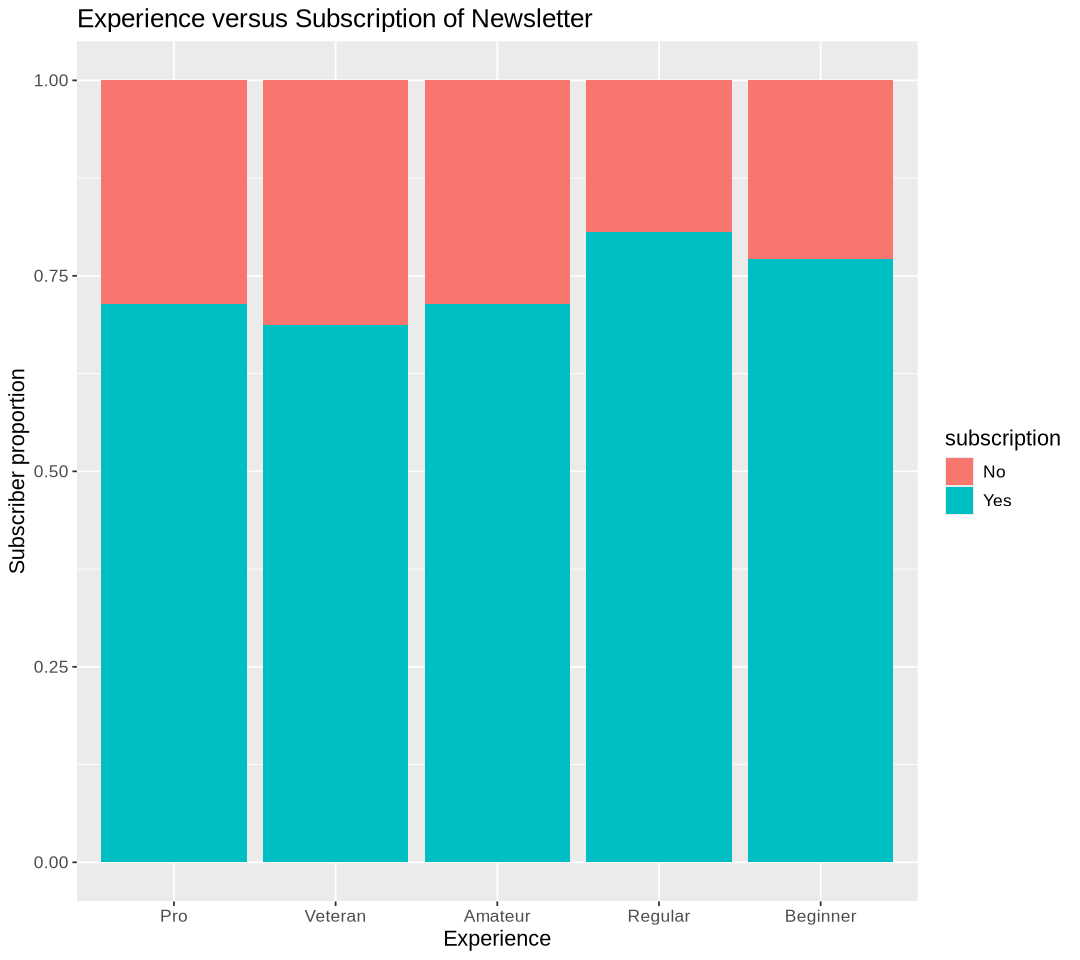

In [18]:
options(repr.plot.width=9,repr.plot.height=8)
gender_bar <- players|>
    ggplot(aes(x= gender, fill=subscribe))+
    geom_bar(position="fill")+
    labs(x="Gender", y= "Subscriber proportion", fill="subscription")+
    ggtitle("Gender versus Subscription of Newsletter")+
    scale_fill_discrete(labels=c("No", "Yes"))+
    theme(text=element_text(size=13))

experience_bar <- players|>
    ggplot(aes(x= experience, fill=subscribe))+
    geom_bar(position="fill")+
    labs(x="Experience", y= "Subscriber proportion", fill="subscription")+
    ggtitle("Experience versus Subscription of Newsletter")+
    scale_fill_discrete(labels=c("No", "Yes"))+
    theme(text=element_text(size=13))

gender_bar
experience_bar

The two plots present different patterns in subscription. The first plot shows that individuals who identify themselves as `agender` and `other` exhibit 100% subscribtion. In constrast, those who identify themselves as `female`, `male`, `non-binary`, `two-spirited` have approximately 75% subscription. However, individuals who selected `prefer not to say` showed a significantly low likelyhood of subscribing. 

The second plot examines the relationship between experience level and subscription and suggested that experience has minimal correlation with  subscription. All levels of experience including `beginner`, `amateur`, `regular`, `veteran`, and `pro` showed the similar subscription rate of 75%. This indicates that the level of experience does not appear to be a strong predictor of their likelyhood to subscribe to the newsletter.

Now, we will analyse the data. Recall that our goal is to preidct whether a player subscribes based on their experience and gender, which makes this a binary classification problem. Therefore, K-NN classification will be the appropriate method since K-NN algorithm is suitable for binary classification problems. There are some limitations such as K-NN can be slow for large datasets, though this is not a problem for now since our datset only contain 169 observations. Nevertheless, there are some issues we need to address before peforming the analysis. Since K-NN classification relies on distance-based calculations, categorical variables such as `experience` and `gender` has to converted into numeric variables.

In [5]:
players <- players|>
    mutate(experience_num=as.numeric(factor(experience)))|>
    mutate(gender_num=as.numeric(factor(gender)))|>
    mutate(subscribe=as_factor(subscribe))
players

experience,subscribe,gender,experience_num,gender_num
<fct>,<fct>,<fct>,<dbl>,<dbl>
Pro,TRUE,Male,1,1
Veteran,TRUE,Male,2,1
Veteran,FALSE,Male,2,1
⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,Prefer not to say,3,4
Amateur,FALSE,Male,3,1
Pro,TRUE,Other,1,7


To keep the data frame tidy, we will select the columns needed.

In [6]:
players_knn <- players|>
    select(experience_num, gender_num, subscribe)
players_knn

experience_num,gender_num,subscribe
<dbl>,<dbl>,<fct>
1,1,TRUE
2,1,TRUE
2,1,FALSE
⋮,⋮,⋮
3,4,FALSE
3,1,FALSE
1,7,TRUE


After creating the data frame, we will split the data frame into 70-30 for training and testing sets.

In [7]:
set.seed(2000)
players_split <- initial_split(players, prop=0.7)
players_train <- training(players_split)
players_test <- testing(players_split)

In the following steps, we will create a modeling workflow to determine the optimal number of neighbors k for the K-NN classifier. This process has four key components: creating a recipe, define a model specification, perform 5-fold cross-validation, and create an accuracy plot.

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5613757,5,0.01588183,Preprocessor1_Model1
2,accuracy,binary,0.5539683,5,0.01786155,Preprocessor1_Model2
3,accuracy,binary,0.6558405,5,0.04024420,Preprocessor1_Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
7,accuracy,binary,0.7363451,5,0.01705137,Preprocessor1_Model7
8,accuracy,binary,0.7511600,5,0.01638412,Preprocessor1_Model8
9,accuracy,binary,0.7440374,5,0.01343674,Preprocessor1_Model9


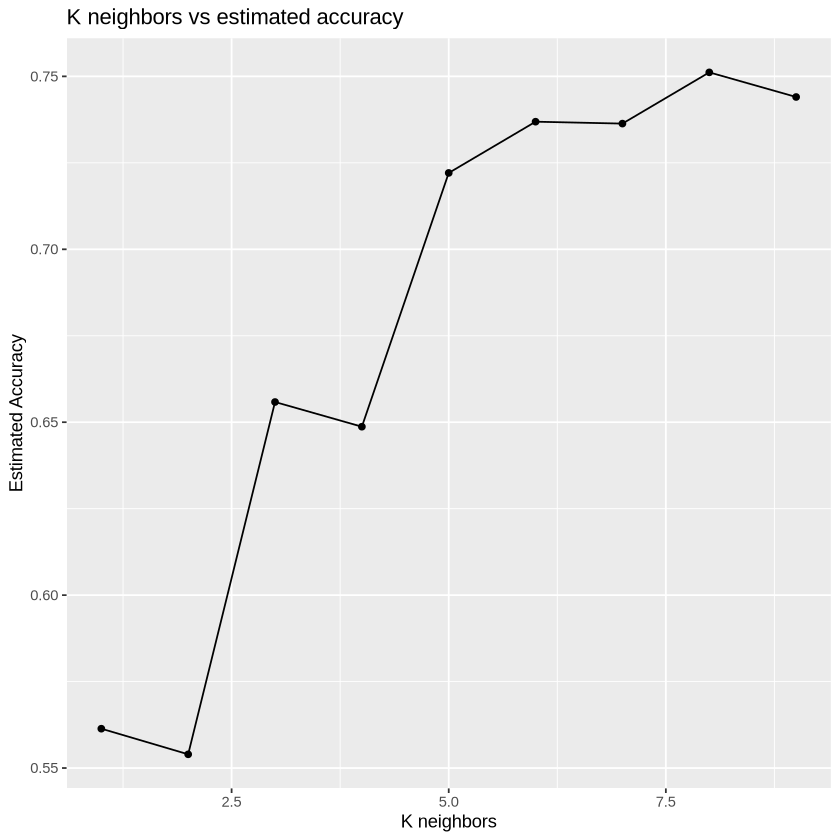

In [8]:
players_recipe <- recipe(subscribe~ gender_num+experience_num, data=players_train)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors= tune())|>
    set_engine("kknn")|>
    set_mode("classification")

train_vfold <- vfold_cv(players_train, v=5, strata= subscribe)

k_vals <- tibble(neighbors=seq(from=1, to=9))

knn_results <- workflow()|>
    add_recipe(players_recipe)|>
    add_model(knn_spec)|>
    tune_grid(resamples=train_vfold,grid=k_vals)|>
    collect_metrics()|>
    filter(.metric=="accuracy")

accuracy_plot <- ggplot(knn_results, aes(x=neighbors, y= mean))+
    geom_point()+
    geom_line()+
    labs(x="K neighbors", y="Estimated Accuracy")+
    ggtitle("K neighbors vs estimated accuracy")
   

knn_results
accuracy_plot

Based on the plot, using 8 neighbors appears to have the highest estimated accuracy. Therefore, we will be using k=8 to make a new model specification. This updated model will be fitted to the training data, and the performace of the classifier will be evaluated on the test set using  `predict` function to determine the classification accuracy..

In [19]:
players_spec <- nearest_neighbor(weight_func="rectangular", neighbors=8)|>
    set_engine("kknn")|>
    set_mode("classification")

players_fit <- workflow()|>
    add_recipe(players_recipe)|>
    add_model(players_spec)|>
    fit(data=players_train)

players_test_preds <- predict(players_fit, players_test)|>
    bind_cols(players_test)|>
    metrics(truth=subscribe, estimate= .pred_class)


accuracy<- players_test_preds|>
    filter(.metric == "accuracy")|> 
    select(.estimate)
   

players_test_preds
accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.69491525
kap,binary,0.04151625


.estimate
<dbl>
0.6949153


This classifier achieved an accuracy of 69.5% in predicting whether players would subscribe. This result is lower than expected based on the cross-validation accuracy plot. This can possibly caused by the random variation in the test set or the model is overfitting.

## Discussion

In this project, we investigated the influence of gender and experience on the subscription of newsletter using `players.csv`. First, we started with visualizing the relationship between `gender`, `experience`, and `subscribe`. The visualization showed that gender may have an impact on subscription, whereas experience appeared to have little to no impact. 

To futher explore the relationship, we developed a K-NN classification model to predict the subscription based on gender and experience. As a result, the classifier has a 69.5% of accuracy, which wa lower than expected. The can be caused by the k-nearest neighbors is too big so that it overfitted or the random variation in the test set. To improve the model's accuracy, additional predictor variable can be helpful. Including relevant variables can increase the classifier's ability to identify the subscription of players by understanding the relationships that are not explained by gender and experience.

In future applications,similar predicitve models could be used to understand players' behaviour in more detail. For example, predicting the types of advertisements a play is more likely to engage with. This helps the game develops to optimize the best ad placement within the gaming environments. 